# <center> MODEL DEPLOYMENT </center>

## <center> CLASSIFICATION OF RESEARCH PAPER BASED ON ABSTRACT & TITLE </center>

## Group 8 :
###                  Bhavyasree Sasindra (6660767) 
###                  Lakshmi Rajagopalan (6676096)
###                  Preethi Patrick (6674957)
###                  Prasanna Kadiyala (6670385)
###                  Vaibhav Sardana (6669263)

## MODEL SELECTION FOR FINAL DEPLOYMENT

Our team experimented with onevsrest with linearSVC,neural network,word2vec with SVC,label powerset with logistic regression and bert.
The evaluation metrics was used to compare the model performance. The below tables explains the metrics for each model. 

#### Onevsrest With LinearSVC
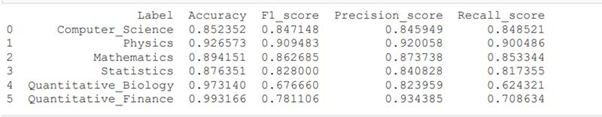

#### Neural Network
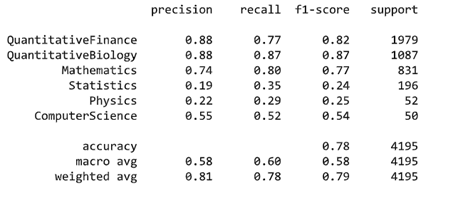

#### Word2vec With SVC
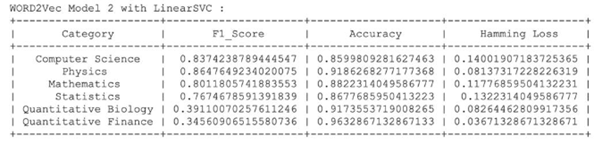

#### Label Powerset With Logistic Regression
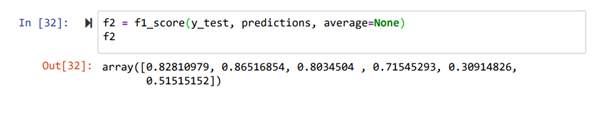

#### Bert With Neural Network
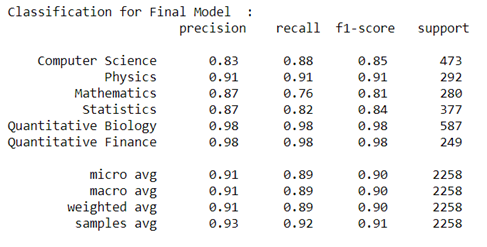

Among all the model we experimented,we decided to go with Bert due to high f1 score.
Bert is one of the state of the art NLP models. It is very flexible. Bert can be retrained for n number of NLP tasks such as question-answering, sequence classification, which is what our project is about. Bert also makes it very easy to train language models since none of the traditional pre-processing steps such as stop word removal, n-grams, tokenization is not required. Bert has its own tokenizer and it is very good at understanding which words matter more/less due to its attention mechanism. Another advantage of using bert is that pre-trained models are available even for specific tasks, which makes it easier to retrain the model with very little data. 

# MODEL SERVING

Ideally in a production environment solutions such as tensor flow serving or torch serving can be used.Tensorflow serving is particularly built for serving flexible ML models in production. But for the purposes of this project it was decided that a simpler solution like loading the model in flask app would do the task.
Flask gives us a variety of choices for developing web applications and it gives us the necessary tools and libraries that allow us to build a web application.

The serving.py file portaits how we have handled the model serving.

# WEB SERVICE TO HOST THE MODEL

Front end was developed using Flask. Html and CSS were used to create the web page.

The route function tells the Flask application which URL to render on the webpage.

When the Flask server is run, the saved BERT model is loaded and flask routes to the default URL path ‘/’, which renders the index.htm file. This webpage contains a form where the user can enter the abstract to be classified.

On submitting the form, the abstract is then given to the model for prediction. The model gives a list of confidence scores, which shows the probability of each class. Class label of 1 is assigned for those classes with confidence scores greater than 0.5. The confidence scores and the assigned class labels are then returned. Classes having value 1 will be assigned to the abstract. A bar chart of confidence scores vs labels is plotted. Flask then renders the result.html page which displays the predicted labels and the bar plot.

The index.py will start the flask server.

# MONITORING OF THE SERVICE

Data can change over time. This might lead to change in underlying relationships between inputs and outputs, thereby leading to poor performance of the model. For monitoring purpose, we have captured the user inputs and the predicted labels to a csv file. When there is a concept drift, this file can be used to retrain the model.

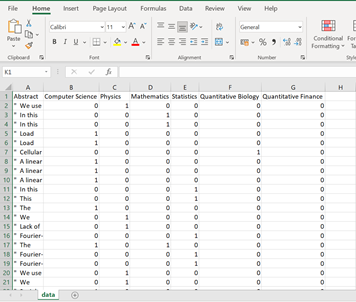

We wrote a script that sends n abstracts to the end point and we track the time taken for each request and provided an aggregated result.
```python
def test_topic_modeller(abstracts):
    timings = []
    for abstract in abstracts:
        start_time = time.time()
        requests.post("http://localhost:8080/classify", data={"abstract": abstract})
        end_time = time.time()
        print("Took {} second(s)".format(end_time - start_time))
        timings.append(end_time - start_time)
    average_timing = sum(timings) / len(timings)
    print("On average it took {} seconds for a request \n And it took {} seconds to process {} abstracts".format(
        average_timing, sum(timings), len(timings)))

n = 5
data = pd.read_csv("data.csv")
abstracts = data.loc[:n, "Abstract"].values

test_topic_modeller(abstracts)
```
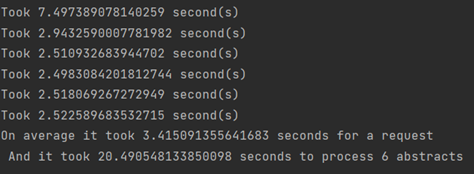

Memory usage was also noted manually. These numbers were observed on a CPU but on production it would be ideal to run it on a GPU or specialized hardware such as TPU. Tensor flow serving would also give us features such as batching that makes scaling of the service easier. 
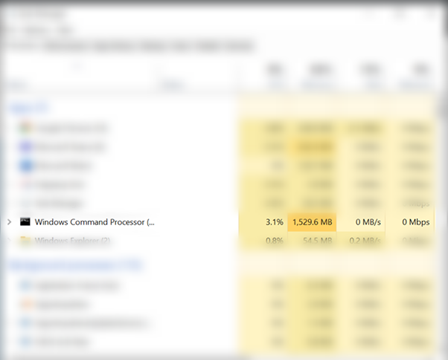

# PIPELINE

Luigi is a python package that helps to build pipelines for batch processing. With Luigi , it is easy to build pipelines consisting of thousands of the tasks which takes long time to complete . A list of process is chained together with the required output.

The Luigi pipeline is created to perform the following task: Load Data, Train Model , Evaluate Model , Deploy Model. The pipeline will take the new train.csv to retrain the model . The Model thus trained will be deployed in the Flask application. Ideally the pipeline is triggered when there is drift in performance of the model. We have used Luigi with that in mind.

In [1]:
!pip install luigi transformers

     |████████████████████████████████| 1.2MB 7.7MB/s 
     |████████████████████████████████| 2.3MB 48.2MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 
     |████████████████████████████████| 901kB 49.5MB/s 
  Created wheel for luigi: filename=luigi-3.0.3-cp37-none-any.whl size=1077023 sha256=6c1d5092cb37aeae230c4f3465b0a7fe803440136fbfa9adf4e6b1ec2f8df035
  Stored in directory: /root/.cache/pip/wheels/21/70/4d/7f2ee53d02c478106a9f7c6ea7a77985f7cbe61fbbe0cd56cf
Successfully built luigi


In [2]:
import os
import pickle
import luigi
import pandas as pd
from sklearn.metrics import f1_score
import bert
import trainer
import utils

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [3]:
artifact_directory = "artifacts"

In [4]:
class LoadData(luigi.Task):

    def output(self):
        return luigi.LocalTarget(os.path.join(artifact_directory, "data.pkl"))

    def run(self):
        data = pd.read_csv("train.csv")
        with open(self.output().path, "wb") as outfile:
            pickle.dump(data, outfile)
        print("Data loading done!")

In [5]:
class TrainModel(luigi.Task):

    def requires(self):
        return LoadData()

    def run(self):
        classes = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology",
                   "Quantitative Finance"]
        with open(self.input().path, "rb") as in_file:
            data = pd.read_pickle(in_file)
        data["text"] = data["TITLE"] + " ." + data["ABSTRACT"]
        Y = data[classes].values
        version = "final_1"
        processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
        model = bert.BertToSingleLayerNeuralNetwork(config=bert.ModelConfig)
        model.version = version
        model.build(processors=processors)
        trainer_methodology = trainer.KFoldTrainer(config=trainer.TrainerConfig, model=model)
        trainer_methodology.initialize(x=data["text"], y=Y)
        model.save("artifacts")
        with self.output().open("w") as file:
            file.write("artifacts")

    def output(self):
        return luigi.LocalTarget('model_path.txt')

In [6]:
class EvaluateModel(luigi.Task):

    def requires(self):
        return TrainModel()

    def run(self):
        version = "final_1"
        processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
        model = bert.BertToSingleLayerNeuralNetwork(config=bert.ModelConfig)
        model.version = version
        model.build(processors=processors)
        with open(self.input().path, "r") as input_file:
            directory = input_file.read()
        print("loading model from ", directory)
        model.load(directory=directory)

        validation_dataset = pd.read_csv("train.csv")
        validation_dataset["text"] = validation_dataset["TITLE"] + " ." + validation_dataset["ABSTRACT"]
        y_pred = model.predict(validation_dataset["text"])

        classes = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology",
                   "Quantitative Finance"]
        Y_val = validation_dataset[classes].values
        y_pred_binary = (y_pred > 0.5).astype(int)

        f1Score = f1_score(Y_val, y_pred_binary, average='macro')
        print(f1Score)
        with self.output().open("w") as file:
            file.write("artifacts")        

    def output(self):
        return luigi.LocalTarget('eval.txt')

#for the purpose of our project we are saving the model to a folder name "model". For production this trained model will replace the drifted model.


In [7]:
class DeployModel(luigi.Task):

  def requires(self):
        return EvaluateModel()
  def run(self):
        version = "final_1"
        processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
        model = bert.BertToSingleLayerNeuralNetwork(config=bert.ModelConfig)
        model.version = version
        model.build(processors=processors)
        with open(self.input().path, "r") as input_file:
            directory = input_file.read()
        print("loading model from ", directory)
        model.load(directory=directory)
        model.save("model")
        with self.output().open("w") as file:
            file.write("artifacts")        

  def output(self):
      return luigi.LocalTarget('deploy.txt')

In [8]:
luigi.build([DeployModel()], local_scheduler=True)

DEBUG: Checking if DeployModel() is complete
DEBUG: Checking if EvaluateModel() is complete
INFO: Informed scheduler that task   DeployModel__99914b932b   has status   PENDING
DEBUG: Checking if TrainModel() is complete
INFO: Informed scheduler that task   EvaluateModel__99914b932b   has status   PENDING
DEBUG: Checking if LoadData() is complete
INFO: Informed scheduler that task   TrainModel__99914b932b   has status   PENDING
INFO: Informed scheduler that task   LoadData__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 4
INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) running   LoadData()
INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) done      LoadData()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   LoadData__99914b932b   has stat

Data loading done!


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) done      TrainModel()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   TrainModel__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 2
INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) running   EvaluateModel()
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSe

loading model from  artifacts


INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) done      EvaluateModel()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   EvaluateModel__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) running   DeployModel()


0.22542112609822443


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


loading model from  artifacts


INFO: [pid 59] Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) done      DeployModel()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   DeployModel__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=640473852, workers=1, host=17995f5b609f, username=root, pid=59) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 4 tasks of which:
* 4 ran successfully:
    - 1 DeployModel()
    - 1 EvaluateModel()
    - 1 LoadData()
    - 1 TrainModel()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



True

In [ ]:
!python index.py

The service can be accessed in http://127.0.0.1:8080/

# CONCLUSION

Overall, the project helped us walk through various machine learning modelling approaches , integration with Flask and to deploy them locally.Model Deployment was successfully completed and the model predictions are accurate.
To extend the scope of the project proper drift monitoring setup can be developed. TensorFlow serving can be used for model serving and experimented with other state-of-the-art models such as GPT3, XLNet. CI/CD pipeline can be automated when the model goes to production. 